In [1]:
import h5py
import torch
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# with h5py.File('data/KdV_train_1024_default.h5', 'r') as f:
#     traj_train = torch.tensor(f['train']['pde_140-256'][:], dtype=torch.float32)
# with h5py.File('data/KdV_valid_1024_default.h5', 'r') as f:
#     traj_valid = torch.tensor(f['valid']['pde_140-256'][:], dtype=torch.float32)
# with h5py.File('data/KdV_test_4096_default.h5', 'r') as f:
#     traj_test = torch.tensor(f['test']['pde_140-256'][:], dtype=torch.float32)

class args:
    equation = 'KdV'

class Traj_dataset:
    traj_train = None
    traj_valid = None
    traj_test = None

print('Loading training data...')
with h5py.File(f'data_large/{args.equation}_train_100000_default.h5', 'r') as f:
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
    Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:100, :131], dtype=torch.float32, device=cfg.device)
# print('Loading validation data...')
# with h5py.File(f'data_large/{cfg.equation}_valid_1024_default.h5', 'r') as f:
#     Traj_dataset.traj_valid = torch.tensor(f['valid']['pde_140-256'][:, :131], dtype=torch.float32)
print('Loading test data...')
with h5py.File(f'data_large/{args.equation}_test_100000_default.h5', 'r') as f:
    Traj_dataset.traj_test = torch.tensor(f['test']['pde_140-256'][:100, :131], dtype=torch.float32)

Loading training data...
Loading test data...


In [3]:
from typing import Any, Dict, List, Tuple
import torch.nn.functional as F

class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0) if x.size()[1] > 1 else 1.0

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

def compute_metrics(y, y_pred, d=1) :
    L2_func = LpLoss(d=d, p=2, reduction=False)
    if y.shape != y_pred.shape :
        raise NotImplementedError
    l2 = L2_func.abs(y, y_pred) # [bs]
    relative_l2 = L2_func.rel(y, y_pred) # [bs]
    mse = F.mse_loss(y_pred, y, reduction='none') # [bs]
    mse = mse.mean(dim=tuple(range(1, mse.ndim)))
    return l2, relative_l2, mse


In [4]:
epochs = 100
lr = 0.001
batch_size = 32

In [34]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm

from acquisition.acquirers import select


initial_datasize = 100
batch_acquire = 32
num_acquire = 1
# device = 'cuda'
unrolling=0
nt=14
ensemble_size=5

# unrolling = cfg.get('unrolling', 1)
# nt = cfg.get('nt', 14)
# ensemble_size = cfg.get('ensemble_size', 5)

# def train(X_train, Y_train):
#     model = FNO(n_modes=cfg.model.n_modes, hidden_channels=64,
#                 in_channels=1, out_channels=1)

#     model = model.to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
#     criterion = torch.nn.MSELoss()

#     dataset = torch.utils.data.TensorDataset(X_train, Y_train)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     model.train()
#     for epoch in range(epochs):
#         model.train()
#         max_unrolling = epoch if epoch <= unrolling else unrolling
#         unrolling_list = [r for r in range(max_unrolling + 1)]

#         # Loop over every epoch as often as the number of timesteps in one trajectory.
#         # Since the starting point is randomly drawn, this in expectation has every possible starting point/sample combination of the training data.
#         # Therefore in expectation the whole available training information is covered.
#         total_loss = 0
#         for i in range(nt):
#             for x, y in dataloader:
#                 optimizer.zero_grad()
#                 x, y = x.to(device), y.to(device) # y has shape [batch_size, nt, nx]

#                 unrolled = random.choice(unrolling_list)
#                 bs = x.shape[0]

#                 steps = [t for t in range(0, nt - 1 - unrolled)]
#                 random_steps = random.choices(steps, k=bs)
#                 inputs = torch.stack([y[b, random_steps[b]] for b in range(bs)], dim=0).unsqueeze(1)
#                 outputs = torch.stack([y[b, random_steps[b] + unrolled+1] for b in range(bs)], dim=0).unsqueeze(1)

#                 # pushforward
#                 with torch.no_grad():
#                     model.eval()
#                     for _ in range(unrolled):
#                         inputs = model(inputs)
#                     model.train()
                
#                 pred = model(inputs)
#                 loss = criterion(pred, outputs)

#                 # loss = torch.sqrt(loss)
#                 loss.backward()
#                 optimizer.step()
#                 total_loss += loss.item()
#         scheduler.step()
#     return model

def train(Y, train_nts, **kwargs):
    assert unrolling == 0

    model = FNO(n_modes=cfg.model.n_modes, hidden_channels=64,
                in_channels=1, out_channels=1)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    inputs = []
    outputs = []
    for b in range(Y.shape[0]):
        for t in range(train_nts[b].item()-1):
            inputs.append(Y[b,t])
            outputs.append(Y[b, t+1])
    inputs = torch.stack(inputs, dim=0).unsqueeze(1)
    outputs = torch.stack(outputs, dim=0).unsqueeze(1)

    dataset = torch.utils.data.TensorDataset(inputs, outputs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        model.train()
        # max_unrolling = epoch if epoch <= unrolling else unrolling
        # unrolling_list = [r for r in range(max_unrolling + 1)]

        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)

            # loss = torch.sqrt(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
    return model

def test(model):
    X_test = Traj_dataset.traj_test[:,0,:].unsqueeze(1).to(device)
    Y_test = Traj_dataset.traj_test[:,-1,:].unsqueeze(1).to(device)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    model.eval()

    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            for _ in range(nt-1):
                x = model(x)
            Y_test_pred.append(x)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics


class unrolled_model(torch.nn.Module):
    def __init__(self, model, unrolling):
        super().__init__()
        self.model = model
        self.unrolling = unrolling
    def forward(self, x):
        for _ in range(self.unrolling):
            x = self.model(x)
        return x


results = {'datasize': [], 'rel_l2': []}

timestep = (Traj_dataset.traj_train.shape[1] - 1) // (nt - 1) # 10
assert timestep == 10

X = Traj_dataset.traj_train[:,0].unsqueeze(1).to(device)
Y = Traj_dataset.traj_train[:,0::timestep].to(device)

# train_idxs = torch.arange(initial_datasize, device=device)
# pool_idxs = torch.arange(initial_datasize, X.shape[0], device=device)

train_nts = torch.ones(Y.shape[0], device=device, dtype=torch.int64)

train_nts[:initial_datasize] = nt

# ensemble = [train(Y, train_nts) for _ in tqdm(range(ensemble_size))]

# ensemble = [train(X_train, Y_train) for _ in tqdm(range(ensemble_size))]
ensemble = torch.load('ensemble_50.pt')

# results['datasize'].append(train_idxs.shape[0])
rel_l2_list = [test(model)[1].mean().item() for model in ensemble]
results['rel_l2'].append(torch.mean(torch.tensor(rel_l2_list)).item())
# print(f'{results["datasize"][-1]}, {results["rel_l2"][-1]}')


In [48]:
Y.shape

torch.Size([1000, 14, 256])

In [35]:
ensemble_copy = ensemble

In [42]:
from matplotlib import pyplot as plt
import copy

index = 600
acquired=4
Y = Traj_dataset.traj_train[:,0::timestep]



In [45]:
from matplotlib import pyplot as plt
import copy

epochs = 500
index = 600
acquired=1
Y = Traj_dataset.traj_train[:,0::timestep]

train_nts_new = torch.ones(Y.shape[0], device=device, dtype=torch.int64)
train_nts_new[:initial_datasize] = nt
train_nts_new[index] = acquired
# train_nts_new[index] = nt
model_new = train(Y, train_nts_new)


In [46]:
Y = Traj_dataset.traj_train[:,0::timestep].to(device)

# train_idxs = torch.arange(initial_datasize, device=device)
# pool_idxs = torch.arange(initial_datasize, X.shape[0], device=device)

train_nts = torch.ones(Y.shape[0], device=device, dtype=torch.int64)

train_nts[:initial_datasize] = nt

model_original = train(Y, train_nts)

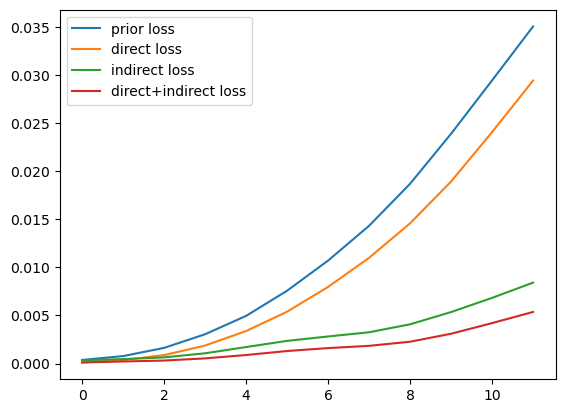

In [47]:

plt.figure()
##############
# Actual loss ( prior)
X = Y[index:index+1, 0:1].to(device)
# print(X.shape)

pred_traj = []

with torch.no_grad():
    for model in [model_original]:
        model.eval()
        pred = X
        pred_traj_single = []
        for _ in range(nt-1):
            pred = model(pred)
            pred_traj_single.append(pred)
        pred_traj.append(torch.cat(pred_traj_single, dim=0))
    pred_traj = torch.stack(pred_traj, dim=0)

# print(pred_traj.shape)
actual_traj = Y[index:index+1, 1:].to(device).unsqueeze(0).permute(0,2,1,3)
loss = torch.mean((pred_traj - actual_traj)**2, dim=0).flatten(start_dim=1).sum(dim=-1)
loss = loss[acquired:]

# print(loss)
plt.plot(loss.cpu().numpy(), label='prior loss')

##############
# Actual loss (direct)
X = Y[index:index+1, acquired:acquired+1].to(device)
# print(X.shape)

pred_traj = []

with torch.no_grad():
    for model in [model_original]:
        model.eval()
        pred = X
        pred_traj_single = []
        for _ in range(nt-acquired-1):
            pred = model(pred)
            pred_traj_single.append(pred)
        pred_traj.append(torch.cat(pred_traj_single, dim=0))
    pred_traj = torch.stack(pred_traj, dim=0)

# print(pred_traj.shape)
actual_traj = Y[index:index+1, acquired+1:].to(device).unsqueeze(0).permute(0,2,1,3)
loss = torch.mean((pred_traj - actual_traj)**2, dim=0).flatten(start_dim=1).sum(dim=-1)

# print(loss)
plt.plot(loss.cpu().numpy(), label='direct loss')


##############
# Actual loss ( indirect)
X = Y[index:index+1, 0:1].to(device)
# print(X.shape)

pred_traj = []

with torch.no_grad():
    for model in [model_new]:
        model.eval()
        pred = X
        pred_traj_single = []
        for _ in range(nt-1):
            pred = model(pred)
            pred_traj_single.append(pred)
        pred_traj.append(torch.cat(pred_traj_single, dim=0))
    pred_traj = torch.stack(pred_traj, dim=0)

# print(pred_traj.shape)
actual_traj = Y[index:index+1, 1:].to(device).unsqueeze(0).permute(0,2,1,3)
loss = torch.mean((pred_traj - actual_traj)**2, dim=0).flatten(start_dim=1).sum(dim=-1)
loss = loss[acquired:]

# print(loss)
plt.plot(loss.cpu().numpy(), label='indirect loss')

##############
# Actual loss (direct+indirect)
X = Y[index:index+1, acquired:acquired+1].to(device)
# print(X.shape)

pred_traj = []

with torch.no_grad():
    for model in [model_new]:
        model.eval()
        pred = X
        pred_traj_single = []
        for _ in range(nt-acquired-1):
            pred = model(pred)
            pred_traj_single.append(pred)
        pred_traj.append(torch.cat(pred_traj_single, dim=0))
    pred_traj = torch.stack(pred_traj, dim=0)

# print(pred_traj.shape)
actual_traj = Y[index:index+1, acquired+1:].to(device).unsqueeze(0).permute(0,2,1,3)
loss = torch.mean((pred_traj - actual_traj)**2, dim=0).flatten(start_dim=1).sum(dim=-1)

# print(loss)
plt.plot(loss.cpu().numpy(), label='direct+indirect loss')


plt.legend()



Number of models in ensemble: 5
Number of models in ensemble: 10
Number of models in ensemble: 15
Number of models in ensemble: 20


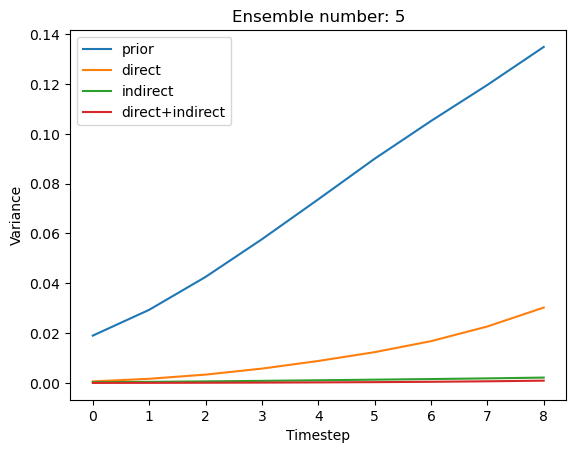

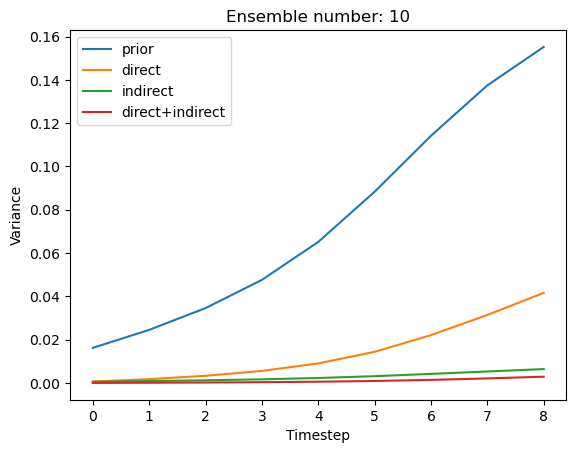

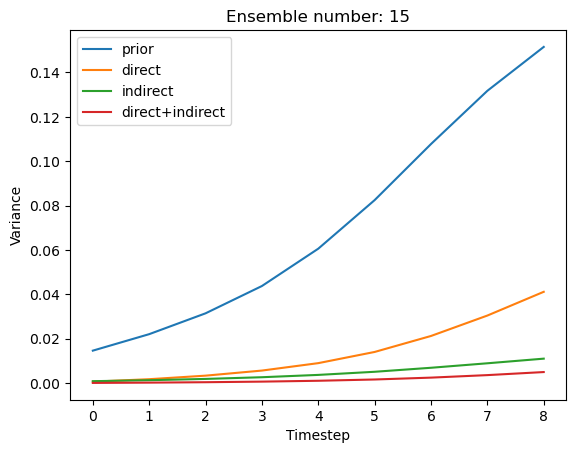

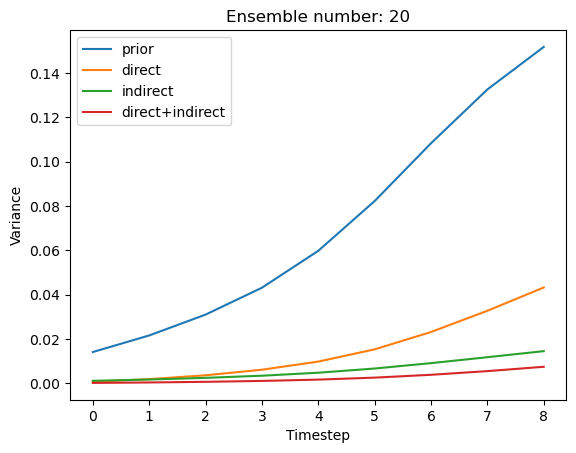

In [44]:


for ensemble_number in range(5,21,5):
    print(f'Number of models in ensemble: {ensemble_number}')
    ensemble = ensemble_copy[:ensemble_number]
    plt.figure()

    ### prior
    X = Y[index:index+1, 0:1].to(device)
    pred_traj = []

    with torch.no_grad():
        for model in ensemble:
            model.eval()
            pred = X
            pred_traj_single = []
            for _ in range(nt-1):
                pred = model(pred)
                pred_traj_single.append(pred)
            pred_traj.append(torch.cat(pred_traj_single, dim=0))
        pred_traj = torch.stack(pred_traj, dim=0)

    # print(pred_traj.shape)

    variance = torch.var(pred_traj, dim=0).sum(dim=-1)
    variance = variance[acquired:]

    # print(variance)
    plt.plot(variance.cpu().numpy(), label='prior')

    ############################################
    # X = ensemble[0](Y[index:index+1, 0:1].to(device))
    # # print(X.shape)

    # pred_traj = []

    # with torch.no_grad():
    #     for model in ensemble:
    #         model.eval()
    #         pred = X
    #         pred_traj_single = []
    #         for _ in range(nt-1):
    #             pred = model(pred)
    #             pred_traj_single.append(pred)
    #         pred_traj.append(torch.cat(pred_traj_single, dim=0))
    #     pred_traj = torch.stack(pred_traj, dim=0)

    # # print(pred_traj.shape)

    # variance = torch.var(pred_traj, dim=0).sum(dim=-1)

    # variance = variance[acquired:]

    # print(variance)


    # plt.plot(variance.cpu().numpy(), label='prior')

    ############################################
    X = Y[index:index+1, acquired:acquired+1].to(device)
    # print(X.shape)

    pred_traj = []

    with torch.no_grad():
        for model in ensemble:
            model.eval()
            pred = X
            pred_traj_single = []
            for _ in range(nt-acquired-1):
                pred = model(pred)
                pred_traj_single.append(pred)
            pred_traj.append(torch.cat(pred_traj_single, dim=0))
        pred_traj = torch.stack(pred_traj, dim=0)

    # print(pred_traj.shape)

    variance = torch.var(pred_traj, dim=0).sum(dim=-1)

    # print(variance)
    plt.plot(variance.cpu().numpy(), label='direct')


    ############################################

    # Predicting variance using Gaussian posterior predictive distribution

    X = Y[index:index+1, 0:1].to(device)

    pred_traj = []

    with torch.no_grad():
        for model in ensemble:
            model.eval()
            pred = X
            pred_traj_single = []
            for _ in range(nt-1):
                pred = model(pred)
                pred_traj_single.append(pred)
            pred_traj.append(torch.cat(pred_traj_single, dim=0))
        pred_traj = torch.stack(pred_traj, dim=0)

    mean = torch.mean(pred_traj, dim=0)
    features_all = pred_traj - mean # [ensemble_size, 13, 1, 256]
    features_all = features_all / np.sqrt(features_all.shape[0]-1) # [ensemble_size, 13, 1, 256]
    features_all = features_all.flatten(2) # [ensemble_size, 13, 256]
    features = features_all[:, 0:acquired].flatten(start_dim=1).unsqueeze(0) # [1, acquired*256]
    features_remember = features

    posterior_variance = []

    for i in range(acquired, nt-1):
        features_target = features_all[:, i:i+1].flatten(start_dim=1)

        std=np.sqrt(1e-4)

        # features = get_features_ycov(X.reshape(bs*bs_acquire, *X.shape[2:]), ensemble) # [bs*bs_acquire, N, dim]
        # features = features.view(bs, bs_acquire, *features.shape[1:]) # [bs, bs_acquire, N, dim]
        # features = features.permute(0,2,1,3).reshape(bs, features.shape[2], -1) # [bs, N, bs_acquire*dim]

        # features_target = get_features_ycov(X_pool, ensemble) # [bs, N, dim]
        # features_target = features_target.permute(1,0,2).reshape(features_target.shape[1], -1) # [N, bs_target*dim]

        # features = features.double()
        # features_target = features_target.double()

        trace_K_nn = torch.einsum('ni,ni->...', features_target, features_target) # []
        temp_woodbury = torch.einsum('bni,bmi->bnm', features, features) # [bs, N, N]
        temp_woodbury = temp_woodbury + torch.eye(features.shape[1], device=features.device).unsqueeze(0) * std**2 # [bs, N, N]
        woodbury_inv = torch.cholesky_inverse(torch.linalg.cholesky(temp_woodbury)) # [bs, N, N]
        # woodbury_inv = torch.cholesky_inverse(torch.vmap(robust_cholesky)(temp_woodbury)) # [bs, N, N]
        woodbury_inv = woodbury_inv * std**2 # [bs, N, N]
        trace_subtract = (-1/(std**4) * torch.einsum('bti,bts,bsj,nk,bnj,mk,bmi->b', features, woodbury_inv, features, features_target, features, features_target, features)
                        + 1/(std**2) * torch.einsum('nk,bni,mk,bmi->b', features_target, features, features_target, features)) # [bs]
        trace_posterior = trace_K_nn - trace_subtract # [bs]
        # score = -1 * trace_posterior
        # score = trace_subtract.float()
        posterior_variance.append(trace_posterior.item())
    # print(posterior_variance)

    plt.plot(posterior_variance, label='indirect')


    ############################################

    # Predicting variance using Gaussian posterior predictive distribution, with unrolling at first step

    X = Y[index:index+1, acquired:acquired+1].to(device)

    pred_traj = []

    with torch.no_grad():
        for model in ensemble:
            model.eval()
            pred = X
            pred_traj_single = []
            for _ in range(nt-acquired-1):
                pred = model(pred)
                pred_traj_single.append(pred)
            pred_traj.append(torch.cat(pred_traj_single, dim=0))
        pred_traj = torch.stack(pred_traj, dim=0)

    mean = torch.mean(pred_traj, dim=0)
    features_all = pred_traj - mean # [ensemble_size, 13, 1, 256]
    features_all = features_all / np.sqrt(features_all.shape[0]-1) # [ensemble_size, 13, 1, 256]
    features_all = features_all.flatten(2) # [ensemble_size, 13, 256]
    features = features_remember

    posterior_variance = []

    for i in range(0, nt-acquired-1):
        features_target = features_all[:, i:i+1].flatten(start_dim=1)

        std=np.sqrt(1e-4)

        # features = get_features_ycov(X.reshape(bs*bs_acquire, *X.shape[2:]), ensemble) # [bs*bs_acquire, N, dim]
        # features = features.view(bs, bs_acquire, *features.shape[1:]) # [bs, bs_acquire, N, dim]
        # features = features.permute(0,2,1,3).reshape(bs, features.shape[2], -1) # [bs, N, bs_acquire*dim]

        # features_target = get_features_ycov(X_pool, ensemble) # [bs, N, dim]
        # features_target = features_target.permute(1,0,2).reshape(features_target.shape[1], -1) # [N, bs_target*dim]

        # features = features.double()
        # features_target = features_target.double()

        trace_K_nn = torch.einsum('ni,ni->...', features_target, features_target) # []
        temp_woodbury = torch.einsum('bni,bmi->bnm', features, features) # [bs, N, N]
        temp_woodbury = temp_woodbury + torch.eye(features.shape[1], device=features.device).unsqueeze(0) * std**2 # [bs, N, N]
        woodbury_inv = torch.cholesky_inverse(torch.linalg.cholesky(temp_woodbury)) # [bs, N, N]
        # woodbury_inv = torch.cholesky_inverse(torch.vmap(robust_cholesky)(temp_woodbury)) # [bs, N, N]
        woodbury_inv = woodbury_inv * std**2 # [bs, N, N]
        trace_subtract = (-1/(std**4) * torch.einsum('bti,bts,bsj,nk,bnj,mk,bmi->b', features, woodbury_inv, features, features_target, features, features_target, features)
                        + 1/(std**2) * torch.einsum('nk,bni,mk,bmi->b', features_target, features, features_target, features)) # [bs]
        trace_posterior = trace_K_nn - trace_subtract # [bs]
        # score = -1 * trace_posterior
        # score = trace_subtract.float()
        posterior_variance.append(trace_posterior.item())
    # print(posterior_variance)

    plt.plot(posterior_variance, label='direct+indirect')

    #######
    plt.xlabel('Timestep')
    plt.ylabel('Variance')
    plt.title(f'Ensemble number: {ensemble_number}')
    plt.legend()


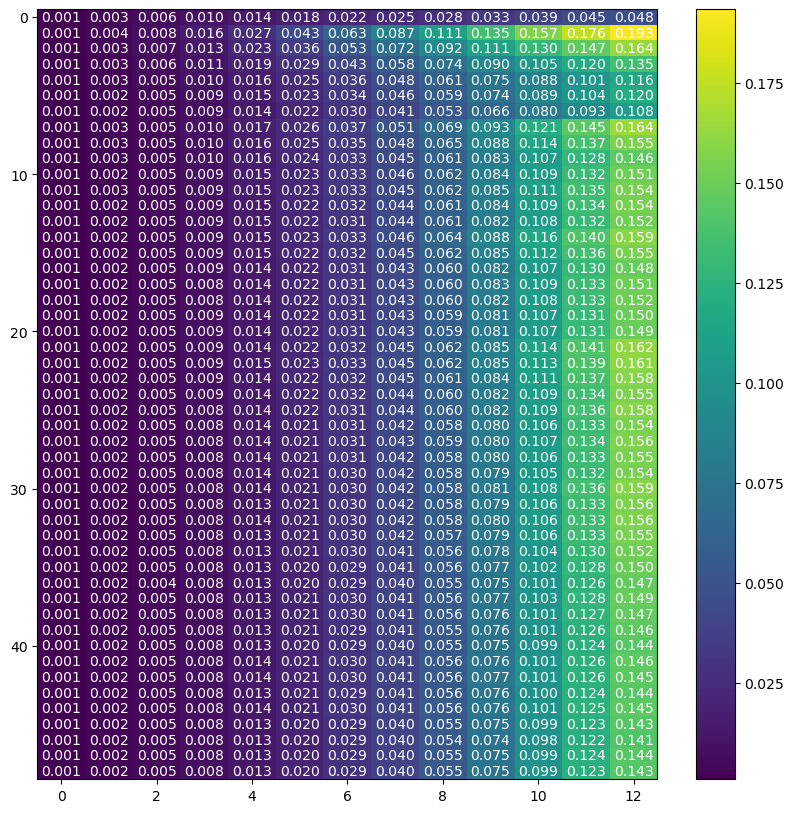

In [ ]:
plt.imshow(variance_list.cpu().numpy(), aspect='auto')
plt.colorbar()
# write numbers
for i in range(variance_list.shape[0]):
    for j in range(variance_list.shape[1]):
        plt.text(j, i, f'{variance_list[i,j].item():.3f}', ha='center', va='center', color='w')
# make bigger so that numbers are readable
plt.gcf().set_size_inches(10, 10)